# 載入套件

In [1]:
import numpy as np
import scipy.io.wavfile as wav
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, time, glob, json, csv
import librosa.display

from python_speech_features import mfcc
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM, Flatten, Embedding, GRU, InputLayer, Reshape
from tensorflow import keras
from keras.utils import to_categorical, plot_model
#from wave import open

Using TensorFlow backend.


# 限制GPU記憶體使用

In [2]:
physical_gpus = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_virtual_device_configuration(
    physical_gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)] 
)
logical_gpus = tf.config.list_logical_devices("GPU")

2022-09-02 23:53:55.952633: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-02 23:53:56.007009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 23:53:56.007235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-02 23:53:56.007614: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-02 23:53:56.010563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-02 23:53:56.012690: I tensorflow/stream_executor/pl

# 準備資料

In [3]:
# https://ithelp.ithome.com.tw/articles/10195763

DATA_PATH = "./dataset/data_sr/x/"
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_pad_len):
    try:
        wave, sr = librosa.load(file_path, mono=True, sr=44100)

        mfcc = librosa.feature.mfcc(y=wave, sr=sr)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width < 0:
            pad_width = 0
            mfcc = mfcc[:,:max_pad_len]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
        
    except:
        print(file_path)

def save_data_to_array(path=DATA_PATH, max_pad_len=104):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_pad_len=max_pad_len)
            mfcc_vectors.append(mfcc)
        print(label+".npy", mfcc_vectors)
        np.save(label + '.npy', mfcc_vectors)


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    
    # Getting first arrays
    X = np.load(labels[0] + '.npy', allow_pickle=True)
    y = np.zeros(X.shape[0])
    

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy', allow_pickle=True)
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - split_ratio), random_state=random_state, shuffle=True)
    X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state, shuffle=True)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=44100)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [ ]:
# 不要取最長的，取已知音檔內容的長度（約不到一秒），轉出的第二個特徵長度是 104，因此固定以這個長度去做截斷與補零
'''
def get_max_pad_len(path):
    labels, _, _ = get_labels(path)
    max_pad_len = 0
    
    for label in labels:
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            mfcc = librosa.feature.mfcc(y=wave, sr=sr)
            if mfcc.shape[1] > max_pad_len:
                max_pad_len = mfcc.shape[1]
                
        print(label + "Done")
        
    return max_pad_len
max_pad_len = get_max_pad_len(path)
'''

In [4]:
save_data_to_array()

yes.npy 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



no.npy 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
X_train, X_test, X_valid, y_train, y_test, y_valid = get_train_test()

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(30101, 20, 104) (30101,)
(3763, 20, 104) (3763,)
(3763, 20, 104) (3763,)


In [11]:
X_train = X_train.reshape(X_train.shape[0], 20, 104, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 104, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 20, 104, 1)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_valid_hot = to_categorical(y_valid)

In [12]:
print(X_train.shape, y_train.shape, y_train_hot.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(30101, 20, 104, 1) (30101,) (30101, 2)
(3763, 20, 104, 1) (3763,)
(3763, 20, 104, 1) (3763,)


# 建立模型

In [27]:
# 3+ 3
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20, 104, 64)       128       
_________________________________________________________________
dense_2 (Dense)              (None, 20, 104, 64)       4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 104, 64)       0         
_________________________________________________________________
dense_3 (Dense)              (None, 20, 104, 32)       2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 104, 32)       0         
_________________________________________________________________
dense_4 (Dense)              (None, 20, 104, 16)       528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 104, 16)      

In [30]:
#simple
model = Sequential()
model.add(InputLayer(input_shape=(20, 68, 1)))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               696832    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [94]:
# GRU
model = Sequential()
model.add(GRU(50, return_sequences=True,
             input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20, 50)            17850     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 50)            15150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [58]:
# LSTM
model = Sequential()
model.add(LSTM(20, return_sequences=True,
              input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20))
model.add(Dropout(0.2))
model.add(Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            23800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [28]:
model.compile(loss="mse",
              optimizer="adam",
              metrics=['accuracy'])

In [26]:
tf.keras.backend.clear_session()

# 訓練模型

In [30]:
def get_model_path(name):
    model_path = name + '/model.h5'
    checkpoint_path = name + '/checkpoints'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    
    return model_path, checkpoint_path, checkpoint_dir, latest

def train_model(model, model_name):
    model_path, checkpoint_path, checkpoint_dir, latest = get_model_path(model_name)

    model_checkpoint_callback = [ModelCheckpoint(checkpoint_path + '/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5',
                                                 monitor='val_accuracy',     
                                                 mode='max',
                                                 save_best_only=True)]
   
    history = model.fit(X_train, y_train_hot, 
                        batch_size=64, epochs=500,
                        validation_data=(X_valid, y_valid_hot),
                        callbacks=model_checkpoint_callback)
    model.save(model_path)
    
    return history, model

In [31]:
history, model = train_model(model, '20220905_sr44100_500epoch')

Train on 30101 samples, validate on 3763 samples
Epoch 1/500
30101/30101 [==============================] - 9s 307us/step - loss: 0.4825 - accuracy: 0.5039 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 2/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4688 - accuracy: 0.5005 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 3/500
30101/30101 [==============================] - 9s 297us/step - loss: 0.4495 - accuracy: 0.5005 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 4/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4529 - accuracy: 0.4984 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 5/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4515 - accuracy: 0.5001 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 6/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4827 - accuracy: 0.4990 - val_loss: 0.5084 - val_accuracy: 0.4916
Epoch 7/500
30101/30101 [==============================] 

30101/30101 [==============================] - 9s 299us/step - loss: 0.4519 - accuracy: 0.4967 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 56/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4531 - accuracy: 0.4985 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 57/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4517 - accuracy: 0.4980 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 58/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4520 - accuracy: 0.4972 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 59/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4514 - accuracy: 0.4973 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 60/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4519 - accuracy: 0.4987 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 61/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4519 - accuracy: 0.4978 - val

30101/30101 [==============================] - 9s 298us/step - loss: 0.4520 - accuracy: 0.4977 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 110/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4522 - accuracy: 0.4958 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 111/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4524 - accuracy: 0.4984 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 112/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4518 - accuracy: 0.4980 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 113/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4522 - accuracy: 0.4981 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 114/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4504 - accuracy: 0.4983 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 115/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4520 - accuracy: 0.4987

30101/30101 [==============================] - 9s 299us/step - loss: 0.4503 - accuracy: 0.4979 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 164/500
30101/30101 [==============================] - 9s 297us/step - loss: 0.4507 - accuracy: 0.4989 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 165/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4523 - accuracy: 0.4970 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 166/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4521 - accuracy: 0.4980 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 167/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4504 - accuracy: 0.4986 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 168/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4505 - accuracy: 0.5000 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 169/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4511 - accuracy: 0.4987

30101/30101 [==============================] - 9s 298us/step - loss: 0.4527 - accuracy: 0.4967 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 218/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4501 - accuracy: 0.5003 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 219/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4525 - accuracy: 0.4976 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 220/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4500 - accuracy: 0.5000 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 221/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4512 - accuracy: 0.4984 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 222/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4506 - accuracy: 0.5006 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 223/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4501 - accuracy: 0.4990

30101/30101 [==============================] - 9s 298us/step - loss: 0.4485 - accuracy: 0.5042 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 272/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4525 - accuracy: 0.4956 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 273/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4524 - accuracy: 0.4980 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 274/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4516 - accuracy: 0.5006 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 275/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4525 - accuracy: 0.4958 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 276/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4510 - accuracy: 0.4994 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 277/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4506 - accuracy: 0.4991

30101/30101 [==============================] - 9s 299us/step - loss: 0.4507 - accuracy: 0.5009 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 326/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4496 - accuracy: 0.4987 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 327/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4515 - accuracy: 0.4992 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 328/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4527 - accuracy: 0.4970 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 329/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4501 - accuracy: 0.4996 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 330/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4528 - accuracy: 0.4953 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 331/500
30101/30101 [==============================] - 9s 304us/step - loss: 0.4502 - accuracy: 0.4983

30101/30101 [==============================] - 9s 298us/step - loss: 0.4490 - accuracy: 0.5025 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 380/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4519 - accuracy: 0.4973 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 381/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4517 - accuracy: 0.4979 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 382/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4534 - accuracy: 0.4981 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 383/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4508 - accuracy: 0.4994 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 384/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4516 - accuracy: 0.4969 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 385/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4513 - accuracy: 0.4992

30101/30101 [==============================] - 9s 297us/step - loss: 0.4496 - accuracy: 0.5024 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 434/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4488 - accuracy: 0.5013 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 435/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4490 - accuracy: 0.4998 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 436/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4526 - accuracy: 0.4966 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 437/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4516 - accuracy: 0.4970 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 438/500
30101/30101 [==============================] - 9s 300us/step - loss: 0.4523 - accuracy: 0.4985 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 439/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4526 - accuracy: 0.4984

30101/30101 [==============================] - 9s 298us/step - loss: 0.4506 - accuracy: 0.4981 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 488/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4488 - accuracy: 0.5041 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 489/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4521 - accuracy: 0.4995 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 490/500
30101/30101 [==============================] - 9s 298us/step - loss: 0.4497 - accuracy: 0.5014 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 491/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4517 - accuracy: 0.4991 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 492/500
30101/30101 [==============================] - 9s 297us/step - loss: 0.4518 - accuracy: 0.4966 - val_loss: 0.4916 - val_accuracy: 0.5084
Epoch 493/500
30101/30101 [==============================] - 9s 299us/step - loss: 0.4488 - accuracy: 0.5005

# 模型評估

- 測試資料集的 loss, accuracy, recall, precision, f1, mse, mae
- 訓練時的 loss, accuracy
- 驗證資料的 loss, accuracy

In [32]:
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
import keras
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    fig = plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))
    return fig

def evaluate_model(model_path, eval_model):
    #eval_model = load_model(model_path)
    
    eval_model.compile(loss='mse',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    print(eval_model.summary())
    
    # loss, acc
    loss_train, accuracy_train = eval_model.evaluate(X_train, y_train_hot, verbose=0)
    loss_val, accuracy_val = eval_model.evaluate(X_valid, y_valid_hot, verbose=0)
    loss_test, accuracy_test = eval_model.evaluate(X_test, y_test_hot, verbose=0)
    print("訓練")
    print("Loss: %0.4f, Accuracy: %0.4f" %(loss_train, accuracy_train))
    print("驗證")
    print("Loss: %0.4f, Accuracy: %0.4f" %(loss_val, accuracy_val))
    print("測試")
    print("Loss: %0.4f, Accuracy: %0.4f" %(loss_test, accuracy_test))
    
    # test precision, recall, f1
    y_pred1 = eval_model.predict(X_test)
    y_pred = np.argmax(y_pred1, axis=1)
    
    precision = precision_score(y_test, y_pred , average="macro")
    recall = recall_score(y_test, y_pred , average="macro")
    f1 = f1_score(y_test, y_pred , average="macro")
    print("Precision: %0.4f, Recall: %0.4f, F1: %0.4f" %(precision, recall, f1))
    
    # test mse, mae
    eval_model.compile(loss="mse", optimizer="adam", metrics=["mae"])
    mse, mae = eval_model.evaluate(X_test, y_test_hot)
    print("MSE: %0.4f, MAE: %0.4f" %(mse, mae))
    
    # test classification report
    y_pred = eval_model.predict_classes(X_test)
    classifi_report = classification_report(y_test, y_pred)
    print(classifi_report)
    
    # loss, accuracy, by epoch
    #fig = plot_loss_accuracy(history)
    #fig.savefig(model_path.split('/')[0] + '/plot.png')

In [33]:
#model_path = '2class_5:5_rnn/model.h5'
#model_path = '2class_5:5_bilstm/model.h5'
#model_path = '2class_origin_rnn/model.h5'
#model_path = '2class_origin_bilstm/model.h5'

#model_path = 'D7_819_notearlystop/model.h5'
#model_path = './831/model.h5'
model_path = '20220905_sr44100_500epoch/model.h5'
evaluate_model(model_path, model)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20, 104, 64)       128       
_________________________________________________________________
dense_2 (Dense)              (None, 20, 104, 64)       4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 104, 64)       0         
_________________________________________________________________
dense_3 (Dense)              (None, 20, 104, 32)       2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 104, 32)       0         
_________________________________________________________________
dense_4 (Dense)              (None, 20, 104, 16)       528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 104, 16)      

/home/bason/.conda/envs/SR/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3763/3763 [==============================] - 0s 80us/step
MSE: 0.4969, MAE: 0.4969
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1870
         1.0       0.50      1.00      0.67      1893

    accuracy                           0.50      3763
   macro avg       0.25      0.50      0.33      3763
weighted avg       0.25      0.50      0.34      3763



/home/bason/.conda/envs/SR/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bason/.conda/envs/SR/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bason/.conda/envs/SR/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from keras.models import load_model
model = load_model('twoNet_250epoch/model.h5')

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

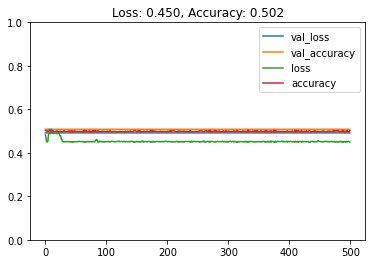

In [35]:
plot_loss_accuracy(history)

# 其他

In [26]:
#print(X_test[0])
y_pred1 = model.predict(X_test)
#print(y_pred1)
y_pred = np.argmax(y_pred1, axis=1)
print(y_pred)
'''
wave, sr = librosa.load('./dataset/data_sr/x_all/1650981038.wav')
mfcc = librosa.feature.mfcc(y=wave, sr=sr)

y_pred1 = model.predict(mfcc)
print(y_pred1)
'''

[1 1 0 ... 0 1 0]


"\nwave, sr = librosa.load('./dataset/data_sr/x_all/1650981038.wav')\nmfcc = librosa.feature.mfcc(y=wave, sr=sr)\n\ny_pred1 = model.predict(mfcc)\nprint(y_pred1)\n"

In [ ]:
# Tensorboard 紀錄訓練時的指標

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return
    
    # model path
def get_model_path(name):
    model_path = name + '/model.h5'
    checkpoint_path = name + '/checkpoints'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    
    return model_path, checkpoint_path, checkpoint_dir, latest

def train_model(model, model_name):
    model_path, checkpoint_path, checkpoint_dir, latest = get_model_path(model_name)
    
    
    my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_accuracy')]
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=my_callbacks)
    '''
    ck_callback = ModelCheckpoint(checkpoint_path + '/weights.{epoch:02d}-{val_f1:.4f}.hdf5',
                                                 monitor='val_accuracy',     
                                                 mode='max',
                                                 save_best_only=True)
    tb_callback = TensorBoard(log_dir=model_name + '/logs', profile_batch=0)
   
    history = model.fit(X_train, y_train, 
              batch_size=32, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[Metrics(valid_data=(X_valid, y_valid)),
                         ck_callback,
                         tb_callback])
     '''
    
    model.save(model_path)
    
    return history, model

In [ ]:
#2class 5:5 BiLSTM M2
model_path = '2class_5:5_bilstm_m2/model.h5'
checkpoint_path = './2class_5:5_bilstm_m2/checkpoints'
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return
    
    # 模型儲存
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    

# 按照 accuracy 保存模型
ck_callback = ModelCheckpoint('./2class_5:5_bilstm_m2/checkpoints/weights.{epoch:02d}-{val_f1:.4f}.hdf5',
                                                 monitor='accuracy',        # 改成 accuracy
                                                 mode='max', verbose=2,
                                                 save_best_only=True,
                                                 save_weights_only=True)
tb_callback = TensorBoard(log_dir='./2class_5:5_bilstm_m2/logs', profile_batch=0)

model.fit(X_train, y_train, 
          batch_size=32, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=[Metrics(valid_data=(X_valid, y_valid)),
                     ck_callback,
                     tb_callback])


model.save(model_path)

In [ ]:
del csv_file, csvfile
gc.collect()

In [ ]:
# 5:5
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

x_train = x.reshape(x.shape[0], (x.shape[1]*x.shape[2]))

X_train_under, y_train_under = undersample.fit_resample(x_train, y)
X_train_under = X_train_under.reshape((X_train_under.shape[0], 108, 494))

unique, counts = np.unique(y_train_under, return_counts=True)

dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(y_valid, return_counts=True)

dict(zip(unique, counts))

In [ ]:
# 將 label為有與 label 為無的檔案名稱取出
with open('file_yes.txt', 'w') as f:
    for file in file_yes:
        f.write(f"{file}\n")

with open('file_no.txt', 'w') as f:
    for file in file_no:
        f.write(f"{file}\n")

In [ ]:
with open('audio_filename.txt', 'w') as f:
    for file in files:
        f.write(f"{file}\n")

In [ ]:
print(y.head())

In [ ]:
with open('audio_test.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in d.items():
        writer.writerow([key, value])

In [ ]:
print(audio.shape)

In [ ]:
x = pd.DataFrame(audio_reshape)
x.head()

In [ ]:
df = pd.merge(x,y, how="right", left_on="檔名", right_on="檔名")

In [ ]:
audio_reshape = audio.reshape(audio.shape[0], -1)

files = []
for(dirpath, dirnames, filenames) in os.walk(audio_path):
    for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):                
                #取得 wav的檔名
                index = filename.index('.')
                filename = filename[:index]
                files.append(filename)
                
#files.remove(1618243237)
#files.remove(1618243179)
#files.remove(1618243233)
'''              
b = {}
c = []
i = 0
for a in aa:
    b = {"檔名":aa[i], "特徵":(audio_reshape)}
    c.append(b)
    i += 1
col = ["檔名", "特徵"]
try:
    with open('audio_csv.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=col, delimiter =",")
        writer.writeheader()

        for data in c:
            writer.writerow(data)
except IOError:
    print("I/O error")
'''

In [ ]:
#
audio_reshape.astype(np.float32)
print(audio_reshape.shape)

In [ ]:
#files

import os
# 取得 label 檔名與內容
def get_labels_and_texts(label_path):
    labels = []
    labels_path = []
    label_texts = []
    for(dirpath, dirnames, filenames) in os.walk(label_path):
        for filename in filenames:
            
            #取得 label 的完整路徑，後面進行讀檔
            filename_path = os.path.join(dirpath, filename)
            labels_path.append(filename_path)

            #取得 label的檔名，後面對應到音檔
            
            try:
                index = filename.index("_")
            except ValueError:
                index = filename.index(".")

            filename = filename[:index]
            
            labels.append(filename)
    for label_file in labels_path:
        #讀取 label 檔，並將 command 以 one-hot encoding 方式改寫 label
        try:
            with open(label_file) as fd:
                data = json.load(fd)
                a = 0
                #b = 0
                #c = 0
                #d = 0
                if data['command'] == 'Not Activated':
                    a = '0'
                else:
                    a = '1'
                data = [a]
                label_texts.append(data)
                fd.close()
        except ValueError:
            continue
    return labels, label_texts

label_path = 'dataset/data_sr/y_data'
labels, label_texts = get_labels_and_texts(label_path)

print(labels[0], label_texts[0])

In [11]:
#files

import os
# 取得 label 檔名與內容
def get_labels_and_texts(label_path):
    labels = []
    labels_path = []
    label_texts = []
    for(dirpath, dirnames, filenames) in os.walk(label_path):
        for filename in filenames:
            
            #取得 label 的完整路徑，後面進行讀檔
            filename_path = os.path.join(dirpath, filename)
            labels_path.append(filename_path)

            #取得 label的檔名，後面對應到音檔
            
            try:
                index = filename.index("_")
            except ValueError:
                index = filename.index(".")

            filename = filename[:index]
            
            labels.append(filename)
    for label_file in labels_path:
        #讀取 label 檔，並將 command 以 one-hot encoding 方式改寫 label
        try:
            with open(label_file) as fd:
                data = json.load(fd)
                command = data['command']
                
                a = 0
                b = 0
                c = 0
                d = 0
                e = 0
                f = 0
                g = 0
                h = 0
                i = 0
                j = 0
                k = 0
                l = 0
                if command == 'Not Activated':
                    a = '1'
                elif command == 'open':
                    b = '1'
                elif command == 'close':
                    c = '1'
                elif command == 'hold':
                    d = '1'
                elif command == 'b1':
                    e = '1'
                elif command == '1':
                    f = '1'
                elif command == '2':
                    g = '1'
                elif command == '10':
                    h = '1'
                elif command == '11':
                    i = '1'
                elif command == 'cancel_1':
                    j = '1'
                elif command == 'cancel_2':
                    k = '1'
                elif command == 'cancel_3':
                    l = '1'
                    
                data = [a, b, c, d, e, f, g, h, i, j, k, l]
                
                label_texts.append(data)
                fd.close()
        except ValueError:
            print(label_file)
    return labels, label_texts

label_path = 'dataset/data_sr/y_data'
labels, label_texts = get_labels_and_texts(label_path)

print(labels[0], label_texts[0])

dataset/data_sr/y_data/1621260098.json
dataset/data_sr/y_data/1635565858.json
dataset/data_sr/y_data/1621260094.json
dataset/data_sr/y_data/1627775229.json
dataset/data_sr/y_data/1637748628.json
dataset/data_sr/y_data/1620877500.json
dataset/data_sr/y_data/1618243179.json
dataset/data_sr/y_data/1620877516.json
dataset/data_sr/y_data/1620955238.json
dataset/data_sr/y_data/1629341570.json
dataset/data_sr/y_data/1630587053.json
dataset/data_sr/y_data/1637748622.json
dataset/data_sr/y_data/1637544260.json
dataset/data_sr/y_data/1623546876.json
dataset/data_sr/y_data/1635565854.json
dataset/data_sr/y_data/1627775236.json
dataset/data_sr/y_data/1619576718.json
dataset/data_sr/y_data/1620898178.json
dataset/data_sr/y_data/1626860170.json
dataset/data_sr/y_data/1629341577.json
dataset/data_sr/y_data/1620898181.json
dataset/data_sr/y_data/1627775238.json
dataset/data_sr/y_data/1620955240.json
dataset/data_sr/y_data/1618243233.json
dataset/data_sr/y_data/1626860172.json
dataset/data_sr/y_data/16

In [7]:
with open('dataset/data_sr/y_data/1633931464.json') as fd:
    data = json.load(fd)
    print(data)

{'alternative': [{'transcript': '請開門', 'confidence': 0.890154}, {'transcript': '好請開門'}, {'transcript': '好慶開嗎'}, {'transcript': '寶慶開嗎'}, {'transcript': '好請開嗎'}], 'final': True, 'strength': 0.0037480354309082017, 'command': 'open'}


In [ ]:
path = 'dataset/data_sr/y_data'     

#獲取該目錄下所有文件，存入列表中
fileList = os.listdir ( path )

n = 0
for(dirpath, dirnames, filenames) in os.walk(label_path):
    for filename in filenames:
        
        #取得 label 的完整路徑，後面進行讀檔
        oldname = os.path.join(dirpath, filename)
        
        try:
            index = filename.index("_")
        except ValueError:
            index = filename.index(".")

        filename = filename[:index]
        
        #print(filename)

        #設置新文件名
        newname = path + os.sep + filename + '.json'
        print(oldname)
        print(newname)
        os . rename ( oldname , newname ) #用os模塊中的rename方法對文件改名print ( oldname , '======>' , newname ) 
        n += 1
        #if n > 10: break

  

    

In [12]:
import csv
#將 檔名與 label 寫入 csv 檔

i = 0
for label_text in label_texts:
    label_text.insert(0, labels[i])
    i+=1

with open('dataset/data_sr/label_11class.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['檔名','open', 'close', 'hold', 'b1', '1', '2', '10', '11', 'cancel_1', 'cancel_2', 'cancel_3'])
    
    for label_text in label_texts:
        writer.writerow(label_text)
print(label_texts[0])


['1632204672', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# 將 檔名與特徵寫入 csv 檔

aa = []
for(dirpath, dirnames, filenames) in os.walk(audio_path):
    for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):                
                #取得 wav的檔名
                index = filename.index('.')
                filename = filename[:index]
                aa.append(filename)

a_list = list(audio)
i = 0
b = {}
c = []
for a in a_list:
    b = {"檔名":aa[i],"特徵": a}
    c.append(b)
    i+=1
col = ["檔名", "特徵"]
try:
    with open(audio_csv_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=col)
        writer.writeheader()
        #writer.writerow(['檔名','特徵'])

        for data in c:
            writer.writerow(data)
except IOError:
    print("I/O error")


In [ ]:
# 3D Numpy array to a CSV file
# reshaping the array from 3D matrice to 2D matrice.
arrReshaped = arr.reshape(arr.shape[0], -1)
# saving reshaped array to file.
np.savetxt(filename, arrReshaped)
# retrieving data from file.
loadedArr = np.loadtxt(filename)
# This loadedArr is a 2D array, therefore we need to convert it to the original array shape.
# reshaping to get original matrice with original shape.
loadedOriginal = loadedArr.reshape(loadedArr.shape[0], loadedArr.shape[1] // arr.shape[2], arr.shape[2])

In [ ]:
#load label csv into pd to preview data
labels = pd.read_csv(label_csv_path)
labels

In [ ]:
#load audio csv into pd to preview data

#audios = pd.read_csv(audio_csv_path)
#audios


with open(audio_csv_path, 'r') as f:
    reader = csv.reader(f)
    examples = list(reader)
del examples[0]
#print(examples)

nwexamples = []
for row in examples:
    nwrow = []
    for r in row:
        #could not convert string to float:
        r = np.array(r, dtype=np.float32)
        nwrow.append(r)
    nwexamples.append(nwrow)
print(nwexamples[0])

In [ ]:
m,n,r = audio.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),audio.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

X = out_df[out_df.columns[:]].values   #dead kernel


#np.savetxt('audio.csv', audio, delimiter=',')    # can't save filename

In [ ]:
# using python_speech_features to extract mfcc feartures
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy
import os

# directory where we your .wav files are
directoryName = "dataset/data_sr/data" # put your own directory here
# directory to put our results in, you can change the name if you like
resultsDirectory = 'dataset/data_sr/audio_sample'

# make a new folder in this directory to save our results in
if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)

# get MFCCs for every .wav file in our specified directory 
for filename in os.listdir(directoryName):
    if filename.endswith('.wav'): # only get MFCCs from .wavs
        # read in our file
        
        try:
            (rate,sig) = wav.read(directoryName + "/" +filename)
        except ValueError:
            continue
        # get mfcc
        mfcc_feat = mfcc(sig,rate)

        # get filterbank energies
        fbank_feat = logfbank(sig,rate)
        
        # create a file to save our results in
       
        outputFile = resultsDirectory + "/" + os.path.splitext(filename)[0] + ".csv"
        file = open(outputFile, 'w+') # make file/over write existing file
        numpy.savetxt(file, fbank_feat, delimiter=",") #save MFCCs as .csv
        file.close() # close file

In [ ]:
# read all audio sample csv
audio_csvs_path = 'dataset/data_sr/audio_sample'
csv = glob.glob(audio_csvs_path + "/*.csv")

li = []
for filename in csv:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

In [ ]:
# combine all csvs into one
def return_contents(file_name):
    with open(file_name) as infile:
        reader = csv.reader(infile)
        return list(reader)

all_files = os.listdir('dataset/data_sr/audio_sample')
combined_output = []

for file in all_files:
    data = return_contents('dataset/data_sr/audio_sample/{}'.format(file))
    for row in data:
        combined_output.extend(row)

with open('dataset/data_sr/audio_sample_2.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(combined_output)

In [ ]:
# using librosa to extract mfcc features
x, sr = librosa.load(wavs[0])

#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

fs=10
mfccs = librosa.feature.mfcc(x, sr=fs)

print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
audio_reshaped = audio.reshape(audio.shape[0], -1)

np.savetxt("audio.csv", audio_reshaped)

In [ ]:
files = []
for(dirpath, dirnames, filenames) in os.walk(audio_path):
    for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):                
                #取得 wav的檔名
                index = filename.index('.')
                filename = filename[:index]
                files.append(filename)
                
d = dict()
for i in range(len(audio)):
    d[files[i]] = audio[i]
print(len(d))

### Store dictionary d into csv

In [ ]:
audio_path = 'dataset/data_sr/data'

# 將 flac 音檔轉成 wav 音檔
def get_flacs(audio_path):
    flacs = []
    flac_filename = []
    for (dirpath, dirnames, filenames) in os.walk(audio_path):
        for filename in filenames:
            if filename.endswith('.flac'):
                filename_path = os.path.join(dirpath, filename)
                
                index = filename.index(".")
                    
                filename = filename[:index]
                flac_filename.append(filename)
                
                flacs.append(filename_path)
    return flacs, flac_filename

flacs,flac_filename = get_flacs(audio_path)

i = 0
for flac in flacs:
    try:
        audio, sr = sf.read(flac)
    except RuntimeError:
        print(flac)
    sf.write(audio_path+'/'+flac_filename[i]+'.wav', audio, sr, 'PCM_16')
    i+=1

In [ ]:
print(df1["有指令"].value_counts())

# 分出兩個類別的音檔

In [ ]:
audio_filename = []
audio_path = 'dataset/data_sr/x_all'

for(dirpath, dirnames, filenames) in os.walk(audio_path):
    for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):                
                #取得 wav的檔名
                index = filename.index('.')
                filename = filename[:index]
                audio_filename.append(filename)

In [ ]:
print(len(audio_filename))

In [ ]:
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

file_yes = []
file_no = []

for index, row in y.iterrows():
    file = to_str(row['檔名'])
    if (row['指令']==0):
        file_no.append(file)
    else:
        file_yes.append(file)
    #print(row['檔名'], row['指令'])

In [ ]:
print(len(file_yes))

In [ ]:
setA = set(audio_filename)
setB = set(file_yes)
setC = set(file_no)

setYes = setA & setB
setNo = setA & setC

In [ ]:
print(len(setYes), len(setNo))

In [ ]:
import shutil

file_source = 'dataset/data_sr/x_all/'

In [ ]:
file_destination = 'dataset/data_sr/x/yes'

for i in setYes:
        try:
            shutil.move(file_source + i + '.wav', file_destination)
        except:
            print(i)

In [ ]:
file_destination = 'dataset/data_sr/x/no/'

for i in setNo:
        try:
            shutil.move(file_source + i + '.wav', file_destination)
        except:
            print(i)